In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_validData = pd.read_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV.cvs")

In [3]:
# Check sessions per subject
sessions_per_subject = df_validData.groupby('SubjectID')['Session'].max()

# Count how many reached at least Session 5
n_up_to_5 = (sessions_per_subject >= 5).sum()

print(f"Number of subjects who reached Session 5: {n_up_to_5}")


Number of subjects who reached Session 5: 28


In [4]:
df_validData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15879404 entries, 0 to 15879403
Columns: 128 entries, Unnamed: 0 to Unnamed: 0.2
dtypes: bool(1), float64(108), int64(8), object(11)
memory usage: 15.0+ GB


In [5]:
fixationEnd = df_validData[df_validData.events == -2]

In [16]:
n_fix_df = (
   fixationEnd.groupby('SubjectID')
    .size()
    .reset_index(name='NFix')
    .astype({'SubjectID': str})  # convert SID to string
)

In [6]:
# Step 1: Convert timestamp to datetime
fixationEnd['datetime'] = pd.to_datetime(fixationEnd['timeStampDataPointEnd'], unit='s')

# Step 2: For each group, compute fixation rate
grouped = fixationEnd.groupby(['SubjectID', 'Session', 'SessionSubsection'])

fixation_rates = (
    grouped
    .agg(
        n_fixations=('datetime', 'count'),
        start_time=('datetime', 'min'),
        end_time=('datetime', 'max')
    )
    .reset_index()
)

# Step 3: Compute duration and rate
fixation_rates['duration_seconds'] = (fixation_rates['end_time'] - fixation_rates['start_time']).dt.total_seconds()
fixation_rates['fixations_per_second'] = fixation_rates['n_fixations'] / fixation_rates['duration_seconds']

# Show result
print(fixation_rates[['SubjectID', 'Session', 'SessionSubsection', 'fixations_per_second']])


     SubjectID  Session  SessionSubsection  fixations_per_second
0          365        1                  1              3.278833
1          365        1                  2              3.260948
2          365        1                  3              3.314679
3          365        2                  1              3.235532
4          365        2                  2              3.142034
..         ...      ...                ...                   ...
415       9601        4                  2              3.060269
416       9601        4                  3              3.111603
417       9601        5                  1              3.205971
418       9601        5                  2              3.201185
419       9601        5                  3              2.918439

[420 rows x 4 columns]


/var/folders/wj/11sgsjxd7x75l9tkc6r2l1p80000gn/T/ipykernel_1415/3684018821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixationEnd['datetime'] = pd.to_datetime(fixationEnd['timeStampDataPointEnd'], unit='s')


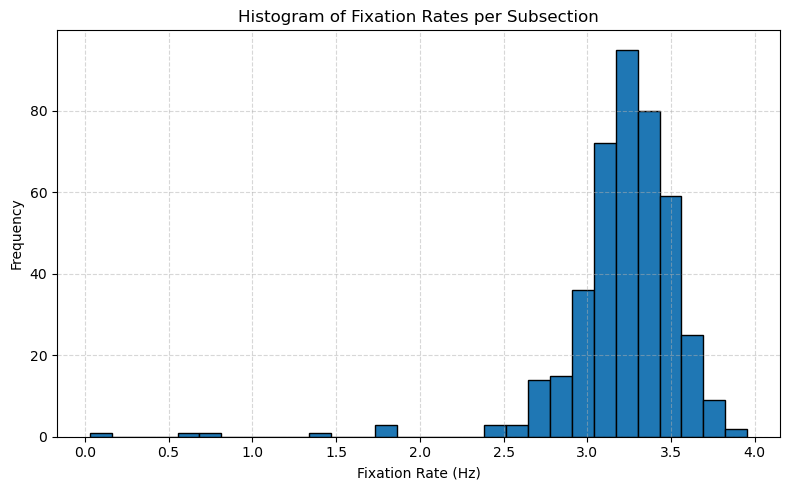

In [7]:
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(fixation_rates['fixations_per_second'].dropna(), bins=30, edgecolor='black')
plt.title('Histogram of Fixation Rates per Subsection')
plt.xlabel('Fixation Rate (Hz)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
fixation_rates['fixations_per_second'].max()

3.954242852055756

In [9]:
# Step 1: Compute the median and MAD for fixation durations
median_length = np.nanmedian(fixationEnd.length)
mad = np.nanmedian(np.abs(fixationEnd.length - median_length))
median_std = mad * 1.4826  # Approximates standard deviation under normality

# Step 2: Compute MAD-based z-scores
fixationEnd['FixDur_mad_z'] = np.abs(fixationEnd.length - median_length) / median_std

# Step 3: Flag outliers based on threshold
fixationEnd['Outlier_FixDur'] = np.where(fixationEnd['FixDur_mad_z'] > 3.5, 'Out', 'Stays')

# Step 4: Create filtered version excluding outliers
fixationEnd_no_out = fixationEnd[fixationEnd['Outlier_FixDur'] != 'Out'].copy()


/var/folders/wj/11sgsjxd7x75l9tkc6r2l1p80000gn/T/ipykernel_1415/2516867557.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixationEnd['FixDur_mad_z'] = np.abs(fixationEnd.length - median_length) / median_std
/var/folders/wj/11sgsjxd7x75l9tkc6r2l1p80000gn/T/ipykernel_1415/2516867557.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixationEnd['Outlier_FixDur'] = np.where(fixationEnd['FixDur_mad_z'] > 3.5, 'Out', 'Stays')


In [10]:
# Sum fixation durations across all sessions per subject
total_fixation_dur = (
    fixationEnd_no_out.groupby('SubjectID')['length']
    .sum()
    .reset_index(name='total_fixation_duration_s')
)

# Convert to seconds if needed
total_fixation_dur['total_fixation_duration_min'] = total_fixation_dur['total_fixation_duration_s'] / 60

# Preview
print(total_fixation_dur.head())


   SubjectID  total_fixation_duration_s  total_fixation_duration_min
0        365                5023.547579                    83.725793
1        479                4755.990074                    79.266501
2       1754                5236.390530                    87.273176
3       2258                4963.828313                    82.730472
4       2361                3820.193646                    63.669894


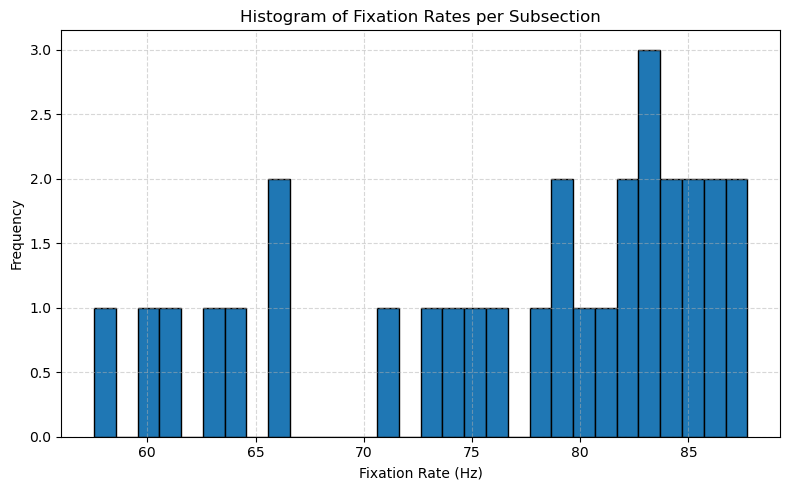

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(total_fixation_dur['total_fixation_duration_min'].dropna(), bins=30, edgecolor='black')
plt.title('Histogram of Fixation Rates per Subsection')
plt.xlabel('Fixation Rate (Hz)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [12]:
fixationEnd_no_out

Unnamed: 0   index  SubjectID  Session  SessionSubsection  \
67                67      67        365        1                  1   
82                82      82        365        1                  1   
88                88      88        365        1                  1   
104              104     104        365        1                  1   
140              140     140        365        1                  1   
...              ...     ...        ...      ...                ...   
15879296      114516  114516        479        3                  3   
15879332      114552  114552        479        3                  3   
15879343      114563  114563        479        3                  3   
15879378      114598  114598        479        3                  3   
15879403      114623  114623        479        3                  3   

          timeStampDataPointEnd  eyeOpennessLeft  eyeOpennessRight  \
67                 1.635519e+09         1.000000          1.000000   
82                 1.635519e+09         1.000000          1.000000   
88                 1.635519e+09         1.000000          1.000000   
104                1.635519e+09         1.000000          1.000000   
140                1.635519e+09         1.000000          1.000000   
...                         ...              ...               ...   
15879296           1.653311e+09         1.000000          1.000000   
15879332           1.653311e+09         1.000000          1.000000   
15879343           1.653311e+09         0.394505          0.794496   
15879378           1.653311e+09         1.000000          1.000000   
15879403           1.653311e+09         1.000000          1.000000   

          pupilDiameterMillimetersLeft  pupilDiameterMillimetersRight  ...  \
67                            2.920517                       3.110687  ...   
82                            2.707687                       3.057800  ...   
88                            2.586441                       2.818451  ...   
104                           2.649963                       3.190781  ...   
140                           3.050369                       3.544373  ...   
...                                ...                            ...  ...   
15879296                      4.548248                       4.544693  ...   
15879332                      4.700668                       4.526855  ...   
15879343                     -1.000000                      -1.000000  ...   
15879378                      5.009796                       4.464920  ...   
15879403                      4.731628                       4.452316  ...   

          events    length    distance    avg_dist                  names  \
67          -2.0  0.288672   26.441740   26.442530          terrain_O.001   
82          -2.0  0.166659   49.794493   49.794525           Building_162   
88          -2.0  0.076880   49.318555   49.320835           Building_162   
104         -2.0  0.211295   19.821159   19.813812       CollisionObject1   
140         -2.0  0.499473   50.795531   50.793834       CollisionObject1   
...          ...       ...         ...         ...                    ...   
15879296    -2.0  0.055271  151.414542  151.523983         OldCityWall_20   
15879332    -2.0  0.100192  106.040492  106.253041         OldCityWall_20   
15879343    -2.0  0.087295   58.652098   58.690015  road_base_network.004   
15879378    -2.0  0.233120   63.973888   64.361575        pileOfClay_LOD0   
15879403    -2.0  0.370016  153.573772  154.142498          terrain_D.001   

          Collider_CategoricalN  Unnamed: 0.2                      datetime  \
67                   Background           NaN 2021-10-29 14:55:47.448322296   
82                     Building           NaN 2021-10-29 14:55:47.681940794   
88                     Building           NaN 2021-10-29 14:55:47.770226717   
104                  Background           NaN 2021-10-29 14:55:47.992929220   
140                  Background           NaN 2021-10-29 14

In [13]:
# Step 1: Compute fixation duration statistics
df_FixDur = (
    fixationEnd_no_out
    .groupby('SubjectID')['length']
    .agg([
        ('FixationDuration_25%', lambda x: np.nanquantile(x, 0.25)),
        ('FixationDuration_med', lambda x: np.nanmedian(x)),
        ('FixationDuration_75%', lambda x: np.nanquantile(x, 0.75)),
        ('FixationDuration_mean', lambda x: np.nanmean(x)),
        ('FixationDuration_sd', lambda x: np.nanstd(x)),
        ('FixationDuration_min', lambda x: np.nanmin(x)),
        ('FixationDuration_max', lambda x: np.nanmax(x))
    ])
    .reset_index()
)

# Step 2: Compute spread and skew
df_FixDur['FixationDuration_DistQ1-Q3'] = (
    df_FixDur['FixationDuration_75%'] - df_FixDur['FixationDuration_25%']
)

df_FixDur['FixationDuration_bowleyCoef'] = (
    (df_FixDur['FixationDuration_75%'] + df_FixDur['FixationDuration_25%']
     - 2 * df_FixDur['FixationDuration_med']) 
    / df_FixDur['FixationDuration_DistQ1-Q3']
)

# Step 3: Drop unused quantiles if desired
df_FixDur = df_FixDur.drop(columns=['FixationDuration_25%', 'FixationDuration_75%'])

# Final output
df_FixDur


SubjectID  FixationDuration_med  FixationDuration_mean  \
0         365              0.155248               0.185727   
1         479              0.144832               0.178167   
2        1754              0.155749               0.184237   
3        2258              0.155248               0.185835   
4        2361              0.155247               0.183232   
5        2693              0.167648               0.191352   
6        3246              0.142822               0.172775   
7        3310              0.151279               0.182182   
8        3572              0.143840               0.175285   
9        3976              0.146816               0.177975   
10       4176              0.144337               0.173744   
11       4597              0.155249               0.186698   
12       4796              0.122015               0.159592   
13       4917              0.144337               0.176314   
14       5238              0.132928               0.163268   
15       5531              0.154127               0.182369   
16       5741              0.143344               0.164479   
17       6642              0.154752               0.181472   
18       7093              0.153761               0.187408   
19       7264              0.144831               0.173349   
20       7412              0.156736               0.191203   
21       7842              0.144337               0.181732   
22       8007              0.155247               0.185068   
23       8469              0.156240               0.190154   
24       8673              0.155247               0.182729   
25       8695              0.136895               0.165867   
26       9472              0.144832               0.169866   
27       9502              0.144333               0.178974   
28       9586              0.133424               0.173356   
29       9601              0.146928               0.181414   

    FixationDuration_sd  FixationDuration_min  FixationDuration_max  \
0              0.123992              0.008928              0.571888   
1              0.119140              0.011407              0.571888   
2              0.119129              0.010912              0.571891   
3              0.125176              0.010912              0.571896   
4              0.120978              0.010911              0.571392   
5              0.118890              0.010911              0.571888   
6              0.119305              0.010911              0.571813   
7              0.122830              0.007437              0.571392   
8              0.120668              0.008927              0.571887   
9              0.117272              0.010415              0.571888   
10             0.114717              0.007440              0.571392   
11             0.123704              0.009424              0.571888   
12             0.117765              0.009426              0.571391   
13             0.119282              0.010417              0.571889   
14             0.114140              0.009920              0.571392   
15             0.121955              0.010911              0.571918   
16             0.106300              0.010415              0.571889   
17             0.117960              0.009423              0.570400   
18             0.129545              0.010912              0.571900   
19             0.112591              0.010912              0.571888   
20             0.126976              0.008432              0.571888   
21             0.126209              0.010417              0.571888   
22             0.124355              0.009918              0.571392   
23             0.126371              0.010912              0.571888   
24             0.122327              0.010912              0.571888   
25             0.111083              0.010911              0.571404   
26             0.107905              0.009424              0.571889   
27             0.125740              0.009919              0.571888   
28             0.12495

In [14]:
# Prepare results list
segment_stats = []

# Loop over each subject
for subject in fixationEnd['SubjectID'].unique():
    df_subj = fixationEnd[fixationEnd['SubjectID'] == subject].copy()

    # Sort by timestamp
    df_subj = df_subj.sort_values('timeStampDataPointEnd')

    # Get segment cutoffs
    q25 = np.nanquantile(df_subj['timeStampDataPointEnd'], 0.25)
    q50 = np.nanquantile(df_subj['timeStampDataPointEnd'], 0.50)
    q75 = np.nanquantile(df_subj['timeStampDataPointEnd'], 0.75)

    # Define segments
    segments = {
        'Segment_0_25': df_subj[df_subj['timeStampDataPointEnd'] <= q25],
        'Segment_25_50': df_subj[(df_subj['timeStampDataPointEnd'] > q25) & (df_subj['timeStampDataPointEnd'] <= q50)],
        'Segment_50_75': df_subj[(df_subj['timeStampDataPointEnd'] > q50) & (df_subj['timeStampDataPointEnd'] <= q75)],
        'Segment_75_100': df_subj[df_subj['timeStampDataPointEnd'] > q75]
    }

    # Compute stats for each segment
    stats_row = {'SubjectID': subject}
    for seg_name, seg_df in segments.items():
        seg_len = seg_df['length']
        stats_row[f'{seg_name}_min'] = np.nanmin(seg_len) if not seg_len.empty else np.nan
        stats_row[f'{seg_name}_max'] = np.nanmax(seg_len) if not seg_len.empty else np.nan
        stats_row[f'{seg_name}_mean'] = np.nanmean(seg_len) if not seg_len.empty else np.nan
        stats_row[f'{seg_name}_median'] = np.nanmedian(seg_len) if not seg_len.empty else np.nan
        stats_row[f'{seg_name}_sd'] = np.nanstd(seg_len) if not seg_len.empty else np.nan

    segment_stats.append(stats_row)

# Create final DataFrame
df_SegmentStats = pd.DataFrame(segment_stats)

# Result
df_SegmentStats


SubjectID  Segment_0_25_min  Segment_0_25_max  Segment_0_25_mean  \
0         365          0.011409        310.165011           0.293814   
1        1754          0.010912          5.308697           0.219425   
2        2258          0.010912        270.723876           0.267649   
3        2361          0.010911        211.846375           0.262829   
4        2693          0.010913        769.133483           0.385540   
5        3246          0.011409        235.272510           0.252706   
6        3310          0.007437         34.983869           0.206887   
7        3572          0.010910        951.832942           0.466283   
8        3976          0.010910         18.967551           0.214354   
9        4176          0.007440        548.499338           0.301177   
10       4796          0.010911        240.321422           0.235612   
11       4917          0.020832        311.264779           0.275565   
12       5238          0.009920        257.929701           0.266195   
13       5531          0.010912         22.467657           0.231759   
14       5741          0.010415        295.454649           0.261146   
15       6642          0.021328        507.176608           0.311256   
16       7093          0.010912        445.905055           0.308332   
17       7264          0.011408        333.359447           0.270642   
18       7412          0.008432        710.475060           0.346779   
19       7842          0.011407        402.358963           0.276891   
20       8007          0.010912        356.567947           0.280804   
21       8469          0.012400       2024.389247           0.548041   
22       8673          0.010912        181.423243           0.242165   
23       8695          0.010911        121.585016           0.207045   
24       9472          0.010912        256.672926           0.250028   
25       9502          0.009919        953.388020           0.380003   
26       9601          0.011407        100.415660           0.235571   
27        479          0.011408        844.701667           0.358545   
28       4597          0.020832         27.154995           0.211636   
29       9586          0.011408        240.769093           0.282103   

    Segment_0_25_median  Segment_0_25_sd  Segment_25_50_min  \
0              0.166655         4.335033           0.010914   
1              0.163183         0.217428           0.021824   
2              0.167151         3.219678           0.011408   
3              0.166655         2.849905           0.011905   
4              0.169641        10.765106           0.011407   
5              0.143840         3.308221           0.010911   
6              0.144832         0.550914           0.011409   
7              0.144831        13.948928           0.010912   
8              0.155248         0.338923           0.010911   
9              0.146320         6.650303           0.021824   
10             0.133920         2.831284           0.010911   
11             0.155244         4.466204           0.011408   
12             0.139873         4.426193           0.010913   
13             0.156240         0.409515           0.010911   
14             0.139872         4.867117           0.010912   
15             0.161695         6.438193           0.021825   
16             0.166656         5.425347           0.021824   
17             0.155248         4.629366           0.011408   
18             0.177072         8.596121           0.021823   
19             0.155496         4.794276           0.010417   
20             0.155744         4.594196           0.011408   
21             0.167152        24.793405           0.010912   
22             0.165169         2.177743           0.010912   
23             0.133921         1.877926           0.022321   
24             0.156240         3.460712           0.011409   
25             0.155248        11.696160           0.010911   
26             0.155248         1.585045           0.011416   
27     

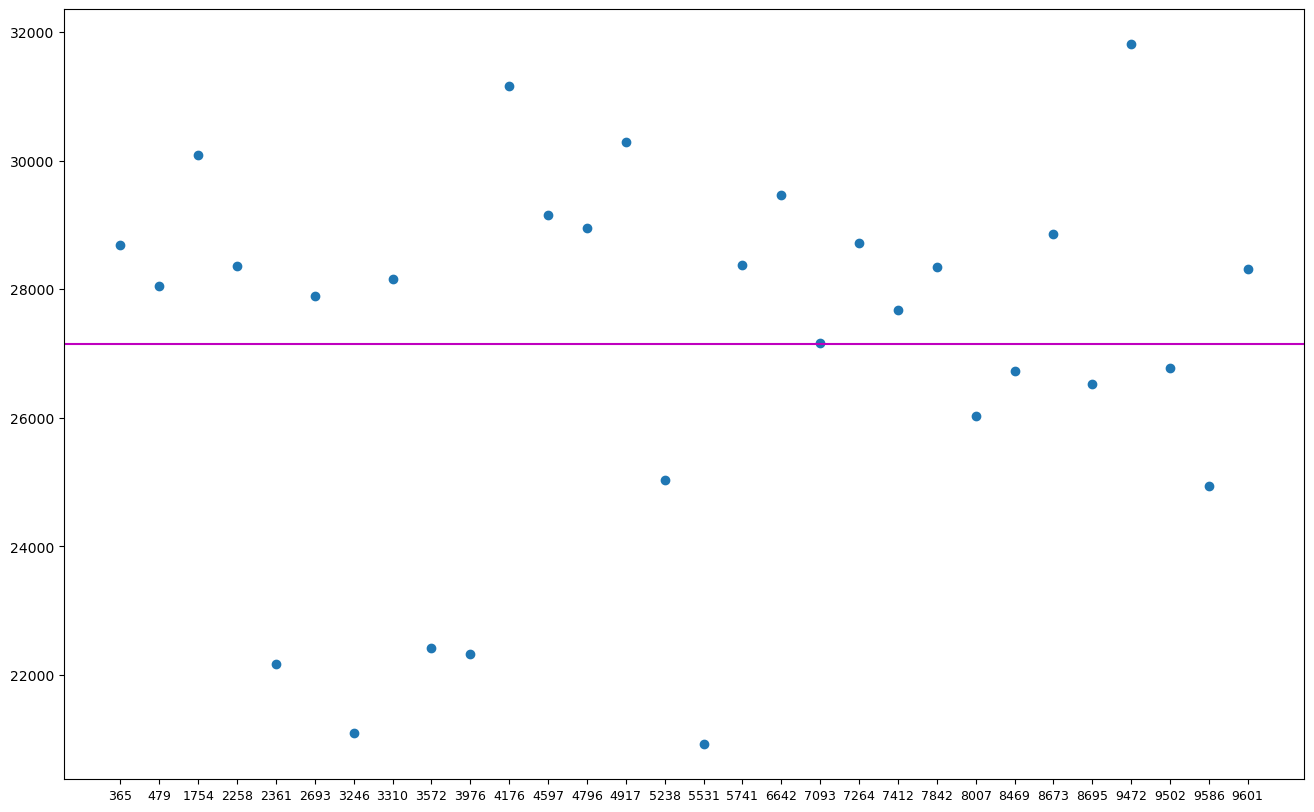

In [18]:
plt.rcParams["figure.figsize"] = (16, 10)
plt.scatter(n_fix_df.SubjectID, n_fix_df["NFix"])
plt.xticks(fontsize=9)
plt.axhline(np.mean(n_fix_df.NFix), color='m')
plt.show()

In [19]:
df_FixDur

SubjectID  FixationDuration_med  FixationDuration_mean  \
0         365              0.155248               0.185727   
1         479              0.144832               0.178167   
2        1754              0.155749               0.184237   
3        2258              0.155248               0.185835   
4        2361              0.155247               0.183232   
5        2693              0.167648               0.191352   
6        3246              0.142822               0.172775   
7        3310              0.151279               0.182182   
8        3572              0.143840               0.175285   
9        3976              0.146816               0.177975   
10       4176              0.144337               0.173744   
11       4597              0.155249               0.186698   
12       4796              0.122015               0.159592   
13       4917              0.144337               0.176314   
14       5238              0.132928               0.163268   
15       5531              0.154127               0.182369   
16       5741              0.143344               0.164479   
17       6642              0.154752               0.181472   
18       7093              0.153761               0.187408   
19       7264              0.144831               0.173349   
20       7412              0.156736               0.191203   
21       7842              0.144337               0.181732   
22       8007              0.155247               0.185068   
23       8469              0.156240               0.190154   
24       8673              0.155247               0.182729   
25       8695              0.136895               0.165867   
26       9472              0.144832               0.169866   
27       9502              0.144333               0.178974   
28       9586              0.133424               0.173356   
29       9601              0.146928               0.181414   

    FixationDuration_sd  FixationDuration_min  FixationDuration_max  \
0              0.123992              0.008928              0.571888   
1              0.119140              0.011407              0.571888   
2              0.119129              0.010912              0.571891   
3              0.125176              0.010912              0.571896   
4              0.120978              0.010911              0.571392   
5              0.118890              0.010911              0.571888   
6              0.119305              0.010911              0.571813   
7              0.122830              0.007437              0.571392   
8              0.120668              0.008927              0.571887   
9              0.117272              0.010415              0.571888   
10             0.114717              0.007440              0.571392   
11             0.123704              0.009424              0.571888   
12             0.117765              0.009426              0.571391   
13             0.119282              0.010417              0.571889   
14             0.114140              0.009920              0.571392   
15             0.121955              0.010911              0.571918   
16             0.106300              0.010415              0.571889   
17             0.117960              0.009423              0.570400   
18             0.129545              0.010912              0.571900   
19             0.112591              0.010912              0.571888   
20             0.126976              0.008432              0.571888   
21             0.126209              0.010417              0.571888   
22             0.124355              0.009918              0.571392   
23             0.126371              0.010912              0.571888   
24             0.122327              0.010912              0.571888   
25             0.111083              0.010911              0.571404   
26             0.107905              0.009424              0.571889   
27             0.125740              0.009919              0.571888   
28             0.12495

In [20]:
# Group and aggregate avg_dist for fixationEnd
df_dist = (
    fixationEnd
    .groupby('SubjectID')
    .agg(
        FixationDist_25pct=('avg_dist', lambda x: np.nanquantile(x, 0.25)),
        FixationDist_med=('avg_dist', np.nanmedian),
        FixationDist_75pct=('avg_dist', lambda x: np.nanquantile(x, 0.75))
    )
    .reset_index()
)
df_dist

/var/folders/wj/11sgsjxd7x75l9tkc6r2l1p80000gn/T/ipykernel_1415/930013486.py:5: FutureWarning: The provided callable <function nanmedian at 0x10c3616c0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  .agg(


SubjectID  FixationDist_25pct  FixationDist_med  FixationDist_75pct
0         365           27.502254         47.523100           83.806535
1         479           21.550537         42.850670           78.749987
2        1754           14.954273         27.407312           50.696729
3        2258           19.091973         37.108386           69.047610
4        2361           17.244703         33.443131           61.765666
5        2693           23.445401         46.603440           89.677958
6        3246           21.146604         37.691913           66.621068
7        3310           22.322810         40.617589           74.855730
8        3572           14.893154         30.736045           60.628783
9        3976           22.777742         39.467957           69.560554
10       4176           16.981739         31.586937           56.374343
11       4597           19.131231         37.155722           70.395623
12       4796           21.397192         39.733153           72.506654
13       4917           20.165869         35.902833           62.334721
14       5238           16.863590         32.623266           62.441186
15       5531           15.309267         28.567821           48.894909
16       5741           17.591016         34.466643           65.457889
17       6642           14.001185         29.299385           56.979373
18       7093           11.074504         22.619615           43.814098
19       7264           18.963172         34.106803           60.068615
20       7412           21.989520         39.619630           70.390902
21       7842           18.974512         33.374724           57.942317
22       8007           16.488671         30.584347           54.635921
23       8469           22.621084         42.001529           75.628091
24       8673           15.424510         30.384862           56.773325
25       8695           20.173460         34.664210           59.358951
26       9472           11.293939         23.206073           47.557904
27       9502           15.936291         32.090622           59.871826
28       9586           19.494043         36.470326           69.444307
29       9601           20.336137         37.060280           67.272953

In [21]:
# Step 4: Compute spread and skew
df_dist['FixationDist_DurQ1-Q3'] = (
    df_dist['FixationDist_75pct'] - df_dist['FixationDist_25pct']
)

df_dist['FixationDist_bowleyCoef'] = (
    (df_dist['FixationDist_75pct'] + df_dist['FixationDist_25pct']
     - 2 * df_dist['FixationDist_med']) 
    / df_dist['FixationDist_DurQ1-Q3']
)

# Step 5: Drop unused quantiles
df_dist = df_dist.drop(columns=['FixationDist_25pct', 'FixationDist_75pct'])

In [22]:
n_fix_df.to_csv("/Volumes/TwoTeras/PCA/Data_Sets/Experiment_1/NFixations.csv", index=False)
df_FixDur.to_csv("/Volumes/TwoTeras/PCA/Data_Sets/Experiment_1/FixationDuration.csv", index=False)
df_dist.to_csv("/Volumes/TwoTeras/PCA/Data_Sets/Experiment_1/DistanceToFixation.csv", index=False)
df_SegmentStats.to_csv("/Volumes/TwoTeras/PCA/Data_Sets/Experiment_1/Fixation_Duration_Segment.csv", index=False)